In [405]:
## which state has the most sightings? over time?
## most frequent shape by state?
## timeline changes? trends?
## sighting density around airports/afb

In [406]:
import os
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

In [553]:
states = {
        'ak': 'Alaska',
        'al': 'Alabama',
        'ar': 'Arkansas',
        'as': 'American Samoa',
        'az': 'Arizona',
        'ca': 'California',
        'co': 'Colorado',
        'ct': 'Connecticut',
        'dc': 'District of Columbia',
        'de': 'Delaware',
        'fl': 'Florida',
        'ga': 'Georgia',
        'gu': 'Guam',
        'hi': 'Hawaii',
        'ia': 'Iowa',
        'id': 'Idaho',
        'il': 'Illinois',
        'in': 'Indiana',
        'ks': 'Kansas',
        'ky': 'Kentucky',
        'la': 'Louisiana',
        'ma': 'Massachusetts',
        'md': 'Maryland',
        'me': 'Maine',
        'mi': 'Michigan',
        'mn': 'Minnesota',
        'mo': 'Missouri',
        'mp': 'Northern Mariana Islands',
        'ms': 'Mississippi',
        'mt': 'Montana',
        'na': 'National',
        'nc': 'North Carolina',
        'nd': 'North Dakota',
        'ne': 'Nebraska',
        'nh': 'New Hampshire',
        'nj': 'New Jersey',
        'nm': 'New Mexico',
        'nv': 'Nevada',
        'ny': 'New York',
        'oh': 'Ohio',
        'ok': 'Oklahoma',
        'or': 'Oregon',
        'pa': 'Pennsylvania',
        'pr': 'Puerto Rico',
        'ri': 'Rhode Island',
        'sc': 'South Carolina',
        'sd': 'South Dakota',
        'tn': 'Tennessee',
        'tx': 'Texas',
        'ut': 'Utah',
        'va': 'Virginia',
        'vi': 'Virgin Islands',
        'vt': 'Vermont',
        'wa': 'Washington',
        'wi': 'Wisconsin',
        'wv': 'West Virginia',
        'wy': 'Wyoming'
}

regions = {
        'Midwest Region
        'Northeast Region
        'South Region
        'West Region
        '


In [583]:
ufo_df = pd.read_csv('resources/ufo2.csv', low_memory=False)
pop_df = pd.read_csv('resources/apportionment.csv')

In [584]:
pop_df.head()

,Name,Geography Type,Year,Resident Population,Percent Change in Resident Population,Resident Population Density,Resident Population Density Rank,Number of Representatives,Change in Number of Representatives,Average Apportionment Population Per Representative
0,Alabama,State,1910,"2,138,093",16.9,42.2,25.0,10.0,1.0,"213,809"
1,Alaska,State,1910,"64,356",1.2,0.1,52.0,NaN,NaN,NaN
2,Arizona,State,1910,"204,354",66.2,1.8,49.0,NaN,NaN,NaN
3,Arkansas,State,1910,"1,574,449",20.0,30.3,30.0,7.0,0.0,"224,921"
4,California,State,1910,"2,377,549",60.1,15.3,38.0,11.0,3.0,"216,051"


In [585]:
pop_df.drop(['Geography Type', 
             'Percent Change in Resident Population', 
             'Resident Population Density', 
             'Resident Population Density Rank', 
             'Number of Representatives', 
             'Change in Number of Representatives', 
             'Average Apportionment Population Per Representative'], axis=1, inplace=True)

In [586]:
pop_df.head()

,Name,Year,Resident Population
0,Alabama,1910,"2,138,093"
1,Alaska,1910,"64,356"
2,Arizona,1910,"204,354"
3,Arkansas,1910,"1,574,449"
4,California,1910,"2,377,549"


In [587]:
nRow, nCol = ufo_df.shape
print(f'This csv has {nRow} rows and {nCol} columns')

This csv has 70388 rows and 12 columns


In [588]:
#split datetime into date and time and move them to the front of the df

ufo_df[['date', 'time']] = ufo_df.datetime.str.split(' ', expand=True)

first_column = ufo_df.pop('time')
ufo_df.insert(0, 'time', first_column)

first_column = ufo_df.pop('date')
ufo_df.insert(0, 'date', first_column)

ufo_df.pop('datetime')

ufo_df.head()

,date,time,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,region
0,5/8/2014,0:00,memphis,tn,us,rectangle,900,15 minutes,Standing at my window around 0:00 brilliantly ...,5/8/2014,35.1494444,-90.048889,Southeast
1,5/7/2014,23:30,san isidro,nm,us,unknown,15,15 seconds,2 red lights gliding across sky&#44 then green...,5/8/2014,35.563363,-106.770591,Southwest
2,5/7/2014,21:20,hillsboro,mo,us,fireball,360,4-6 minutes,Round slow moving silent ball looked like a ca...,5/8/2014,38.2322222,-90.562778,Midwest
3,5/7/2014,21:10,naugatuck,ct,us,unknown,300,5 minutes,Large formation of lights in western sky&#44 f...,5/8/2014,41.4858333,-73.051111,Northeast
4,5/7/2014,21:00,theodore,al,us,circle,120,few minutes,Driving home and entered my neighborhood and s...,5/8/2014,30.5475,-88.175278,Southeast


In [589]:
ufo_df['datetime64'] = pd.to_datetime(ufo_df.date, infer_datetime_format = True)
display(ufo_df.head())

,date,time,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude,region,datetime64
0,5/8/2014,0:00,memphis,tn,us,rectangle,900,15 minutes,Standing at my window around 0:00 brilliantly ...,5/8/2014,35.1494444,-90.048889,Southeast,2014-05-08
1,5/7/2014,23:30,san isidro,nm,us,unknown,15,15 seconds,2 red lights gliding across sky&#44 then green...,5/8/2014,35.563363,-106.770591,Southwest,2014-05-07
2,5/7/2014,21:20,hillsboro,mo,us,fireball,360,4-6 minutes,Round slow moving silent ball looked like a ca...,5/8/2014,38.2322222,-90.562778,Midwest,2014-05-07
3,5/7/2014,21:10,naugatuck,ct,us,unknown,300,5 minutes,Large formation of lights in western sky&#44 f...,5/8/2014,41.4858333,-73.051111,Northeast,2014-05-07
4,5/7/2014,21:00,theodore,al,us,circle,120,few minutes,Driving home and entered my neighborhood and s...,5/8/2014,30.5475,-88.175278,Southeast,2014-05-07


In [590]:
#convert 'duration' column from object to float64

ufo_df.rename(columns = {'duration (seconds)':'duration_sec'}, inplace = True)

ufo_df["duration_sec"] = pd.to_numeric(ufo_df.duration_sec, errors='coerce')

In [591]:
ufo_df.dtypes

date                            object
time                            object
city                            object
state                           object
country                         object
shape                           object
duration_sec                   float64
duration (hours/min)            object
comments                        object
date posted                     object
latitude                        object
longitude                      float64
region                          object
datetime64              datetime64[ns]
dtype: object

In [592]:
ufo_df['shape'] = ufo_df['shape'].replace(
    {'unknown': 'other', 'changed': 'changing', 'flare': 'fireball', 'delta': 'triangle', 'sphere': 'round', 'circle': 'round'})

In [759]:
ufo_df['year'] = pd.DatetimeIndex(ufo_df['datetime64']).year
ufo_df['month'] = pd.DatetimeIndex(ufo_df['datetime64']).month_name()
ufo_df['day'] = pd.DatetimeIndex(ufo_df['datetime64']).day
ufo_df['weekday'] = pd.DatetimeIndex(ufo_df['datetime64']).day_name()
ufo_df.head()

,date,time,city,state,country,shape,duration_sec,duration (hours/min),comments,date posted,latitude,longitude,region,datetime64,year,month,day,weekday,statename,Date Bin
0,5/8/2014,0:00,memphis,tn,us,rectangle,900.0,15 minutes,Standing at my window around 0:00 brilliantly ...,5/8/2014,35.1494444,-90.048889,Southeast,2014-05-08,2014,May,8,Thursday,Tennessee,2010-2015
1,5/7/2014,23:30,san isidro,nm,us,other,15.0,15 seconds,2 red lights gliding across sky&#44 then green...,5/8/2014,35.563363,-106.770591,Southwest,2014-05-07,2014,May,7,Wednesday,New Mexico,2010-2015
2,5/7/2014,21:20,hillsboro,mo,us,fireball,360.0,4-6 minutes,Round slow moving silent ball looked like a ca...,5/8/2014,38.2322222,-90.562778,Midwest,2014-05-07,2014,May,7,Wednesday,Missouri,2010-2015
3,5/7/2014,21:10,naugatuck,ct,us,other,300.0,5 minutes,Large formation of lights in western sky&#44 f...,5/8/2014,41.4858333,-73.051111,Northeast,2014-05-07,2014,May,7,Wednesday,Connecticut,2010-2015
4,5/7/2014,21:00,theodore,al,us,round,120.0,few minutes,Driving home and entered my neighborhood and s...,5/8/2014,30.5475,-88.175278,Southeast,2014-05-07,2014,May,7,Wednesday,Alabama,2010-2015


In [594]:
ufo_df['statename'] = ufo_df['state'].map(states)

In [617]:
ufo_df.head()

,date,time,city,state,country,shape,duration_sec,duration (hours/min),comments,date posted,latitude,longitude,region,datetime64,year,month,day,weekday,statename,Date Bin
0,5/8/2014,0:00,memphis,tn,us,rectangle,900.0,15 minutes,Standing at my window around 0:00 brilliantly ...,5/8/2014,35.1494444,-90.048889,Southeast,2014-05-08,2014,5,8,Thursday,Tennessee,2010-2015
1,5/7/2014,23:30,san isidro,nm,us,other,15.0,15 seconds,2 red lights gliding across sky&#44 then green...,5/8/2014,35.563363,-106.770591,Southwest,2014-05-07,2014,5,7,Wednesday,New Mexico,2010-2015
2,5/7/2014,21:20,hillsboro,mo,us,fireball,360.0,4-6 minutes,Round slow moving silent ball looked like a ca...,5/8/2014,38.2322222,-90.562778,Midwest,2014-05-07,2014,5,7,Wednesday,Missouri,2010-2015
3,5/7/2014,21:10,naugatuck,ct,us,other,300.0,5 minutes,Large formation of lights in western sky&#44 f...,5/8/2014,41.4858333,-73.051111,Northeast,2014-05-07,2014,5,7,Wednesday,Connecticut,2010-2015
4,5/7/2014,21:00,theodore,al,us,round,120.0,few minutes,Driving home and entered my neighborhood and s...,5/8/2014,30.5475,-88.175278,Southeast,2014-05-07,2014,5,7,Wednesday,Alabama,2010-2015


In [621]:
state_sightings = ufo_df['statename'].value_counts().reset_index(name='Number of Sightings')
state_sightings.rename(columns = {'index':'Location'}, inplace = True)
state_sightings.head()

,Location,Number of Sightings
0,California,9584
1,Washington,4240
2,Florida,4175
3,Texas,3638
4,New York,3195


In [655]:
time_sightings = ufo_df['Date Bin'].value_counts().reset_index(name='Number of Sightings')
time_sightings.rename(columns = {'index':'Date Bin'}, inplace = True)
time_sightings.head()

,Date Bin,Number of Sightings
0,2000-2009,31552
1,2010-2015,27737
2,1990-1999,5843
3,1970-1979,1982
4,1980-1989,1773


In [600]:
pop_df.rename(columns = {'Name':'Location'}, inplace = True)
pop_df.head()

,Location,Year,Resident Population
0,Alabama,1910,"2,138,093"
1,Alaska,1910,"64,356"
2,Arizona,1910,"204,354"
3,Arkansas,1910,"1,574,449"
4,California,1910,"2,377,549"


In [608]:
state_pop_sightings = pd.merge(state_sightings, pop_df, on = 'Location', how = "inner")
state_pop_sightings

,Location,Number of Sightings,Year,Resident Population
0,California,9584,1910,"2,377,549"
1,California,9584,1920,"3,426,861"
2,California,9584,1930,"5,677,251"
3,California,9584,1940,"6,907,387"
4,California,9584,1950,"10,586,223"
...,...,...,...,...
619,Puerto Rico,32,1980,"3,196,520"
620,Puerto Rico,32,1990,"3,522,037"
621,Puerto Rico,32,2000,"3,808,610"
622,Puerto Rico,32,2010,"3,725,789"


In [602]:
region_sightings = ufo_df['region'].value_counts().reset_index(name='Number of Sightings')
region_sightings.rename(columns = {'index':'Location'}, inplace = True)
region_sightings.head()

,Location,Number of Sightings
0,West,20736
1,Midwest,14510
2,Southeast,12874
3,Northeast,12407
4,Southwest,9734


In [418]:
state_shape = ufo_df.groupby(['state', 'shape']).size().reset_index(name='count')
state_shape.head()

,state,shape,count
0,ak,changing,5
1,ak,cigar,6
2,ak,cone,1
3,ak,cylinder,5
4,ak,diamond,5


In [612]:
bins = [1940, 1959, 1969, 1979, 1989, 1999, 2009, 2015]


labels = ['1950-1959', '1960-1969', '1970-1979', '1980-1989','1990-1999','2000-2009','2010-2015']

ufo_df['Date Bin'] = pd.cut(ufo_df.datetime64.dt.year, bins, labels=labels, right=False)
ufo_df.head()

,date,time,city,state,country,shape,duration_sec,duration (hours/min),comments,date posted,latitude,longitude,region,datetime64,year,month,day,weekday,statename,Date Bin
0,5/8/2014,0:00,memphis,tn,us,rectangle,900.0,15 minutes,Standing at my window around 0:00 brilliantly ...,5/8/2014,35.1494444,-90.048889,Southeast,2014-05-08,2014,5,8,Thursday,Tennessee,2010-2015
1,5/7/2014,23:30,san isidro,nm,us,other,15.0,15 seconds,2 red lights gliding across sky&#44 then green...,5/8/2014,35.563363,-106.770591,Southwest,2014-05-07,2014,5,7,Wednesday,New Mexico,2010-2015
2,5/7/2014,21:20,hillsboro,mo,us,fireball,360.0,4-6 minutes,Round slow moving silent ball looked like a ca...,5/8/2014,38.2322222,-90.562778,Midwest,2014-05-07,2014,5,7,Wednesday,Missouri,2010-2015
3,5/7/2014,21:10,naugatuck,ct,us,other,300.0,5 minutes,Large formation of lights in western sky&#44 f...,5/8/2014,41.4858333,-73.051111,Northeast,2014-05-07,2014,5,7,Wednesday,Connecticut,2010-2015
4,5/7/2014,21:00,theodore,al,us,round,120.0,few minutes,Driving home and entered my neighborhood and s...,5/8/2014,30.5475,-88.175278,Southeast,2014-05-07,2014,5,7,Wednesday,Alabama,2010-2015


In [611]:
pop_df['Date Bin'] = pd.cut(ufo_df.datetime64.dt.year, bins, labels=labels, right=False)
pop_df

,Location,Year,Resident Population,Date Bin
0,Alabama,1910,"2,138,093",2010-2015
1,Alaska,1910,"64,356",2010-2015
2,Arizona,1910,"204,354",2010-2015
3,Arkansas,1910,"1,574,449",2010-2015
4,California,1910,"2,377,549",2010-2015
...,...,...,...,...
679,Midwest Region,2020,"68,985,454",2010-2015
680,Northeast Region,2020,"57,609,148",2010-2015
681,South Region,2020,"126,266,107",2010-2015
682,West Region,2020,"78,588,572",2010-2015


In [525]:
date_shape = ufo_df.groupby(['Date Bin', 'shape']).size().reset_index(name='count')
date_shape

,Date Bin,shape,count
0,1950-1959,changing,1
1,1950-1959,chevron,3
2,1950-1959,cigar,32
3,1950-1959,cone,1
4,1950-1959,crescent,0
...,...,...,...
149,2010-2015,pyramid,0
150,2010-2015,rectangle,427
151,2010-2015,round,5250
152,2010-2015,teardrop,245


In [637]:
date_region = ufo_df.groupby(['Date Bin','shape']).size().reset_index(name='count')
date_region.head()

,Date Bin,shape,count
0,1950-1959,changing,1
1,1950-1959,chevron,3
2,1950-1959,cigar,32
3,1950-1959,cone,1
4,1950-1959,crescent,0


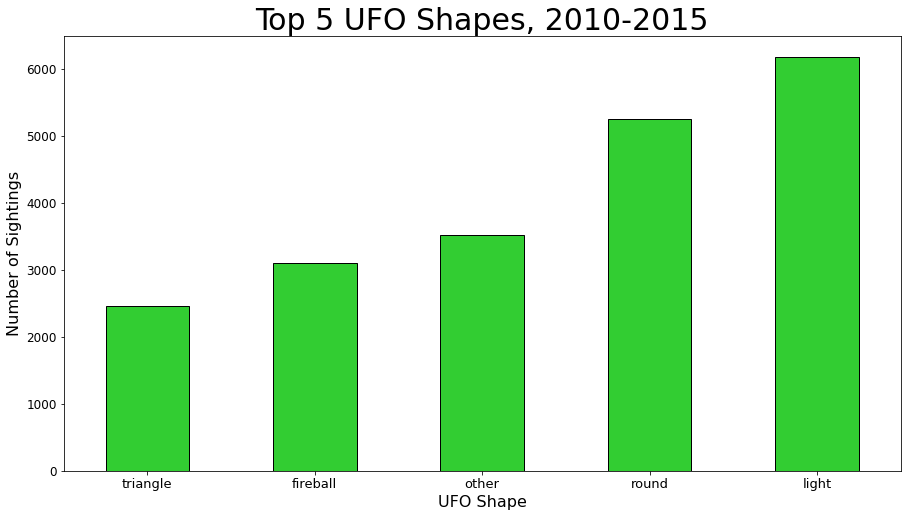

In [782]:
ten_df = date_region.loc[date_region['Date Bin'] == '2010-2015'].set_index('shape').sort_values(by = ['count'], ascending = False).head(5).sort_values(by = ['count'], ascending = True)
ten_df.plot(kind = "bar",color="limegreen",ec="black",figsize=(15,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("UFO Shape", size=16)
plt.title("Top 5 UFO Shapes, 2010-2015", size=30)
plt.show()

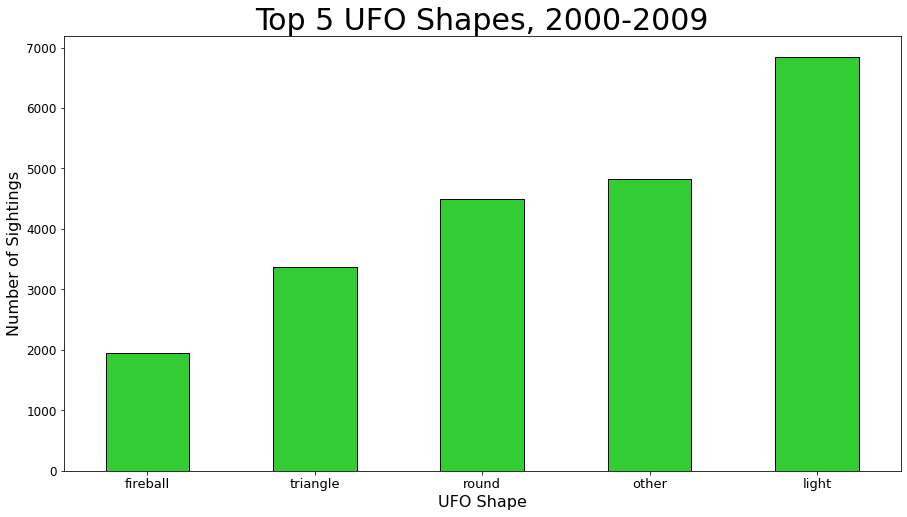

In [783]:
#labels = ['1950-1959', '1960-1969', '1970-1979', '1980-1989','1990-1999','2000-2009','2010-2015']

os_df = date_region.loc[date_region['Date Bin'] == '2000-2009'].set_index('shape').sort_values(by = ['count'], ascending = False).head(5).sort_values(by = ['count'], ascending = True)
os_df.plot(kind = "bar",color="limegreen",ec="black",figsize=(15,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("UFO Shape", size=16)
plt.title("Top 5 UFO Shapes, 2000-2009", size=30)
plt.show()

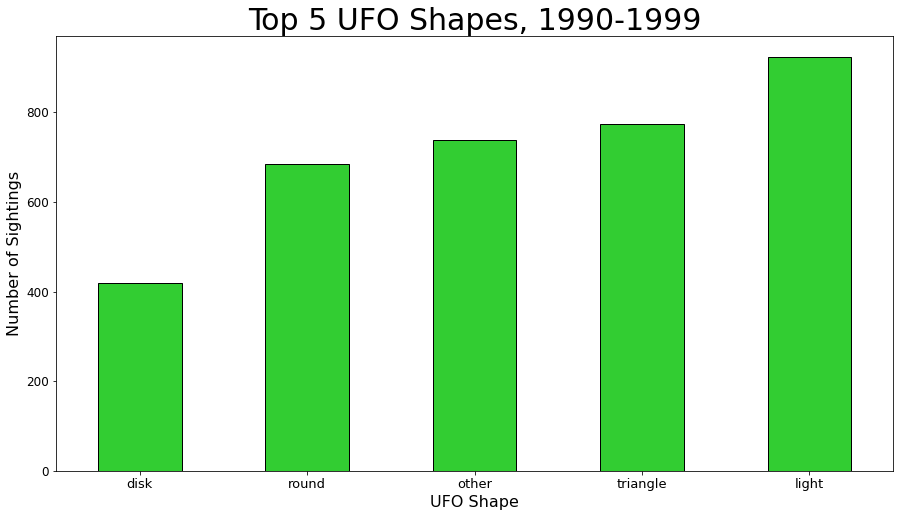

In [808]:
#labels = ['1950-1959', '1960-1969', '1970-1979', '1980-1989','1990-1999','2000-2009','2010-2015']

nines_df = date_region.loc[date_region['Date Bin'] == '1990-1999'].set_index('shape').sort_values(by = ['count'], ascending = False).head(5).sort_values(by = ['count'], ascending = True)
nines_df.plot(kind = "bar",color="limegreen",ec="black",figsize=(15,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("UFO Shape", size=16)
plt.title("Top 5 UFO Shapes, 1990-1999", size=30)
plt.show()

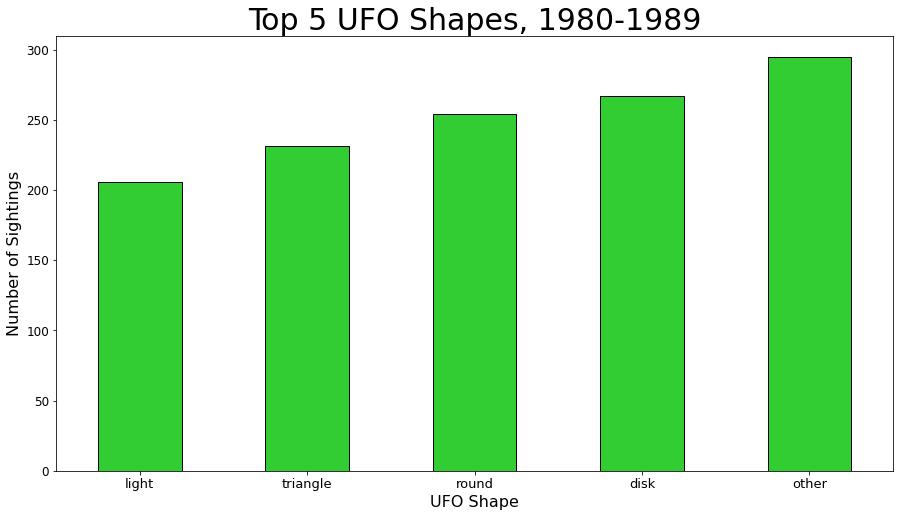

In [809]:
#labels = ['1950-1959', '1960-1969', '1970-1979', '1980-1989','1990-1999','2000-2009','2010-2015']

eights_df = date_region.loc[date_region['Date Bin'] == '1980-1989'].set_index('shape').sort_values(by = ['count'], ascending = False).head(5).sort_values(by = ['count'], ascending = True)
eights_df.plot(kind = "bar",color="limegreen",ec="black",figsize=(15,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("UFO Shape", size=16)
plt.title("Top 5 UFO Shapes, 1980-1989", size=30)
plt.show()

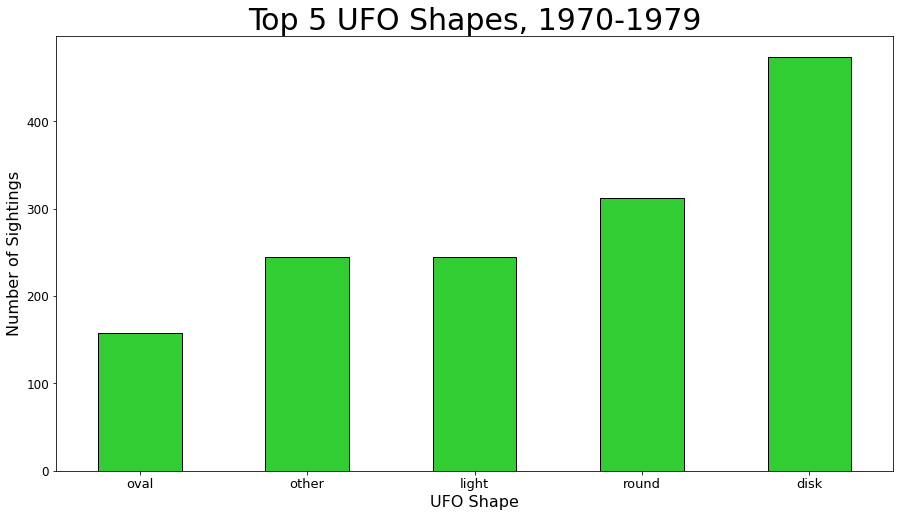

In [810]:
#labels = ['1950-1959', '1960-1969', '1970-1979', '1980-1989','1990-1999','2000-2009','2010-2015']

sevens_df = date_region.loc[date_region['Date Bin'] == '1970-1979'].set_index('shape').sort_values(by = ['count'], ascending = False).head(5).sort_values(by = ['count'], ascending = True)
sevens_df.plot(kind = "bar",color="limegreen",ec="black",figsize=(15,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("UFO Shape", size=16)
plt.title("Top 5 UFO Shapes, 1970-1979", size=30)
plt.show()

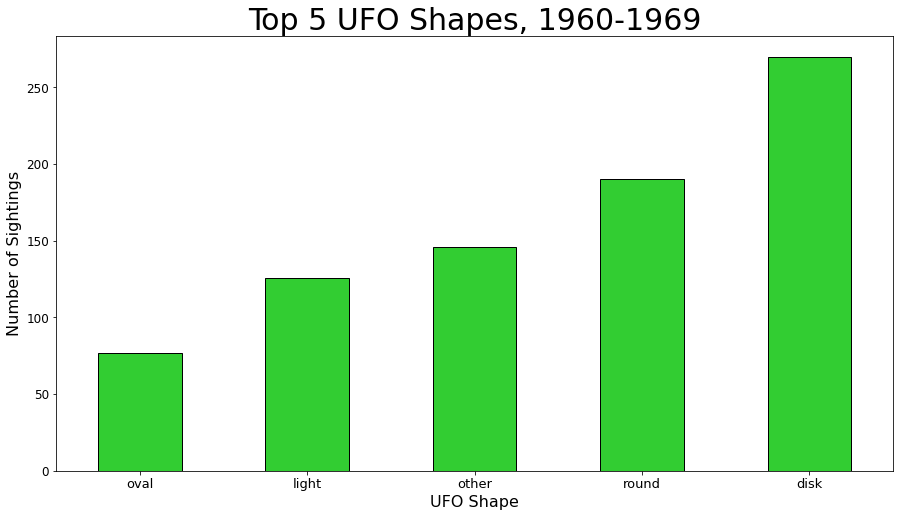

In [811]:
#labels = ['1950-1959', '1960-1969', '1970-1979', '1980-1989','1990-1999','2000-2009','2010-2015']

sixes_df = date_region.loc[date_region['Date Bin'] == '1960-1969'].set_index('shape').sort_values(by = ['count'], ascending = False).head(5).sort_values(by = ['count'], ascending = True)
sixes_df.plot(kind = "bar",color="limegreen",ec="black",figsize=(15,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("UFO Shape", size=16)
plt.title("Top 5 UFO Shapes, 1960-1969", size=30)
plt.show()

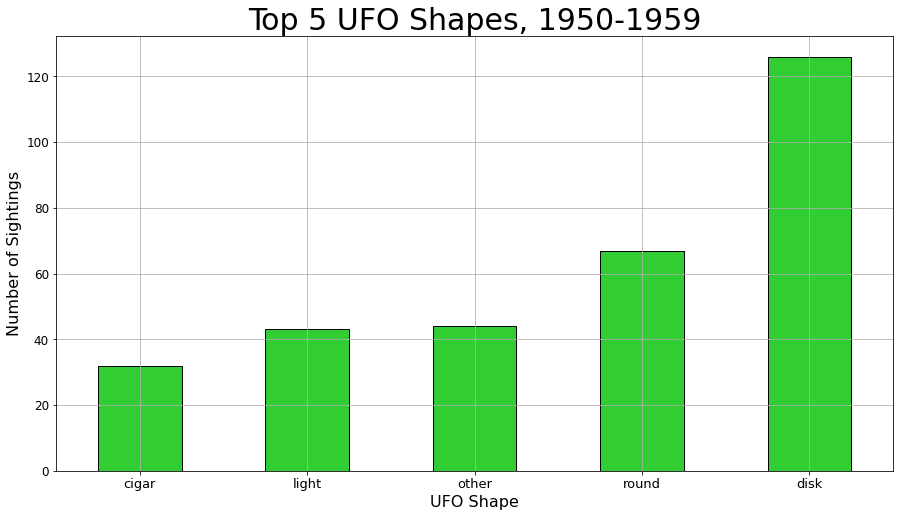

In [812]:
#labels = ['1950-1959', '1960-1969', '1970-1979', '1980-1989','1990-1999','2000-2009','2010-2015']

fives_df = date_region.loc[date_region['Date Bin'] == '1950-1959'].set_index('shape').sort_values(by = ['count'], ascending = False).head(5).sort_values(by = ['count'], ascending = True)
fives_df.plot(kind = "bar",color="limegreen",ec="black",figsize=(15,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("UFO Shape", size=16)
plt.title("Top 5 UFO Shapes, 1950-1959", size=30)
plt.grid(True)
plt.show()

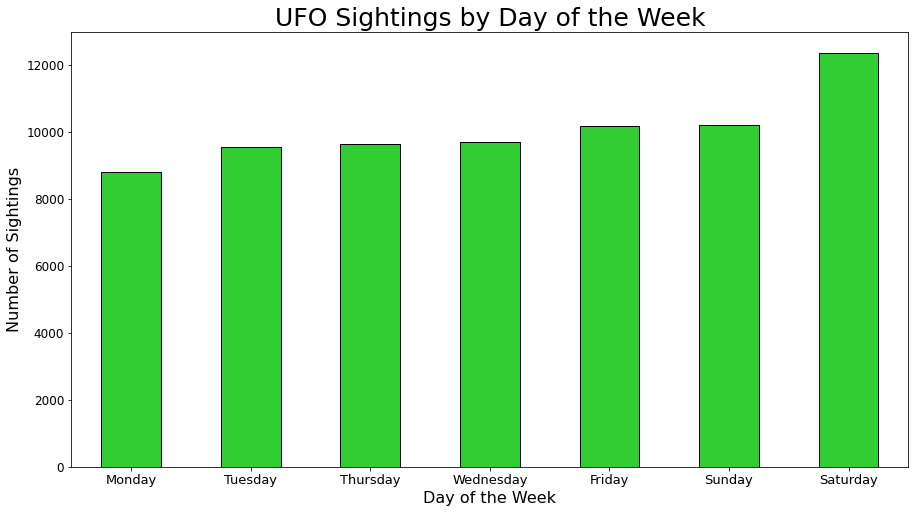

In [807]:
weekdays_df = ufo_df['weekday'].value_counts().sort_values(ascending=True)
weekdays_df.plot(kind='bar',color="limegreen",ec="black",figsize=(15,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("Day of the Week", size=16)
plt.title("UFO Sightings by Day of the Week", size=25)
plt.show()

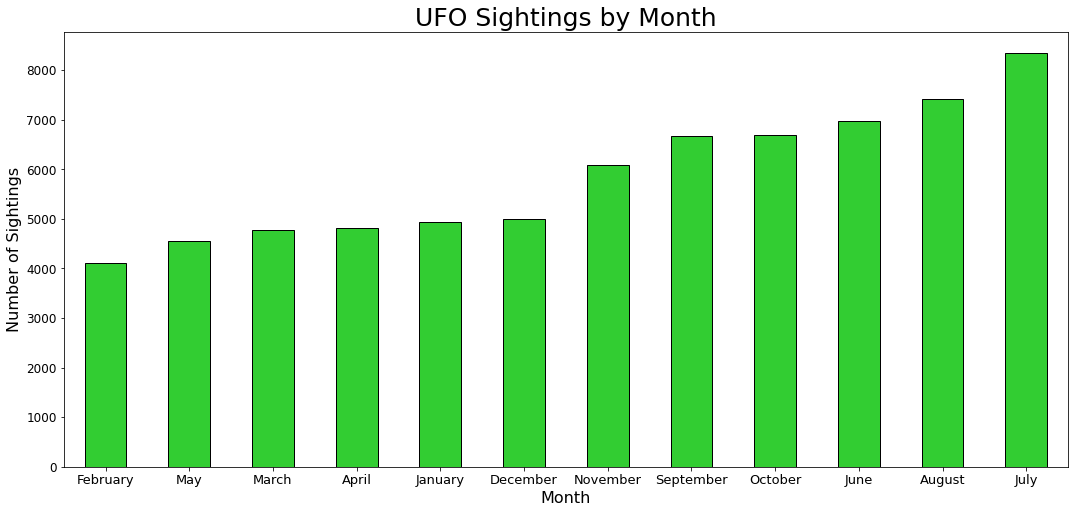

In [780]:
months_df = ufo_df['month'].value_counts().sort_values(ascending=True)
months_df.plot(kind='bar',color="limegreen",ec="black",figsize=(18,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("Month", size=16)
plt.title("UFO Sightings by Month", size=25)
plt.show()

In [421]:
date_shape = date_shape.drop(date_shape.index[date_shape['count'] < 35])

In [422]:
date_shape

,Date Bin,shape,count
8,1950-1959,disk,126
14,1950-1959,light,43
15,1950-1959,other,44
19,1950-1959,round,67
24,1960-1969,cigar,74
...,...,...,...
148,2010-2015,oval,1239
150,2010-2015,rectangle,427
151,2010-2015,round,5250
152,2010-2015,teardrop,245


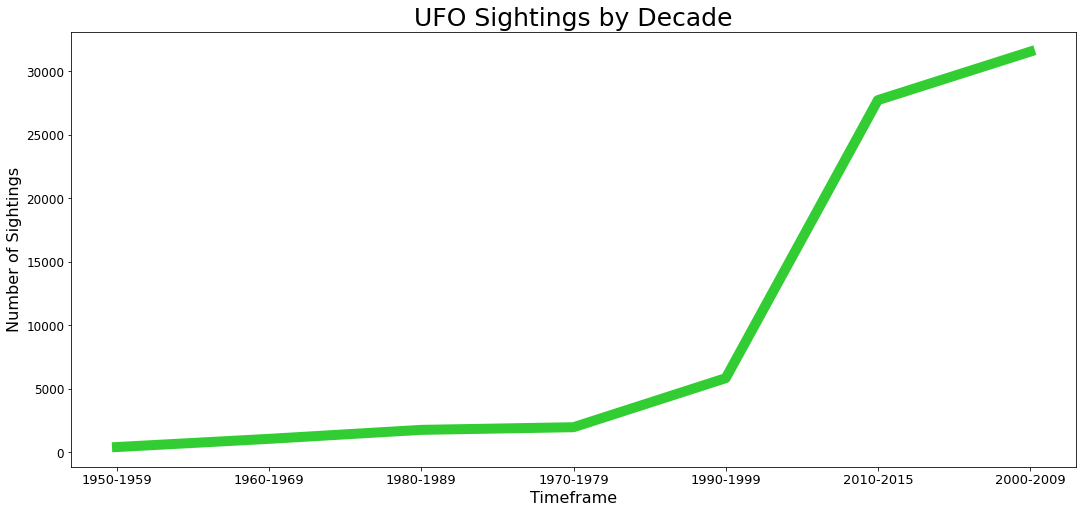

In [806]:
sightings_time = ufo_df.sort_values('datetime64', ascending=True)['Date Bin'].value_counts(ascending=True)
sightings_time.plot(kind='line',color="limegreen",linewidth=10,figsize=(18,8),legend=False)
plt.xticks(size=13, rotation=0)
plt.yticks(size=12)
plt.ylabel("Number of Sightings", size=16)
plt.xlabel("Timeframe", size=16)
plt.title("UFO Sightings by Decade", size=25)
plt.show()

In [445]:
groups = ufo_df.groupby(['shape', pd.cut(ufo_df.year, bins)])
groupsun = groups.size().unstack()

In [496]:
date_state_shape = ufo_df.groupby(['Date Bin', 'state', 'shape']).size().reset_index(name='count').sort_values(by = ['count'], ascending = False)
date_state_shape.head()

,Date Bin,state,shape,count
5822,2000-2009,ca,light,1011
5827,2000-2009,ca,round,771
6966,2010-2015,ca,light,759
5823,2000-2009,ca,other,668
6971,2010-2015,ca,round,591


In [537]:
max_shapes = ufo_df.groupby(['Date Bin', 'region'])['shape'].value_counts().groupby('region').head(5)
max_shapes = pd.DataFrame(max_shapes)
max_shapes.head()

shape
Date Bin  region  shape       
1950-1959 Midwest disk      24
                  other     16
                  round     12
                  light     10
                  cigar      7

region
Midwest      AxesSubplot(0.125,0.125;0.775x0.755)
Northeast    AxesSubplot(0.125,0.125;0.775x0.755)
Southeast    AxesSubplot(0.125,0.125;0.775x0.755)
Southwest    AxesSubplot(0.125,0.125;0.775x0.755)
West         AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

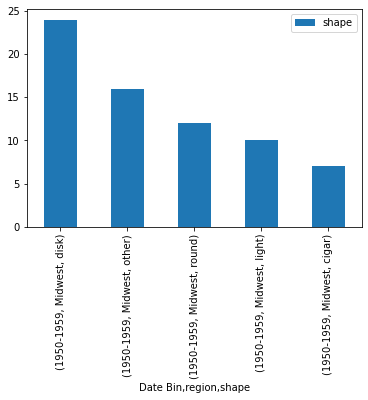

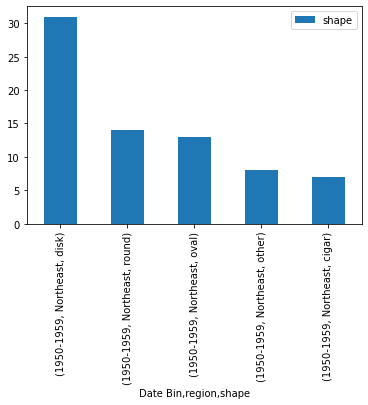

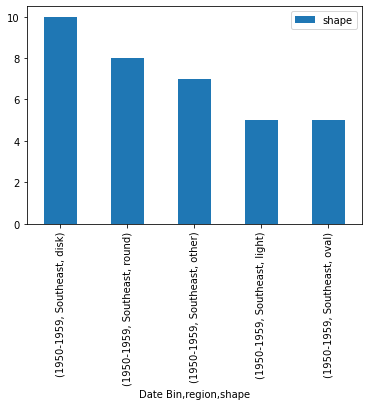

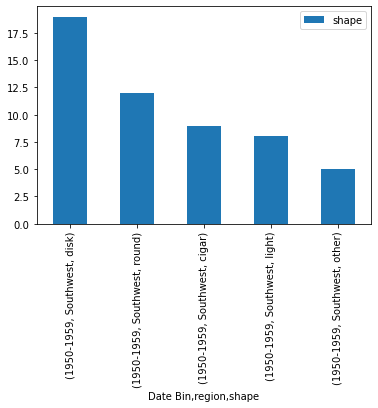

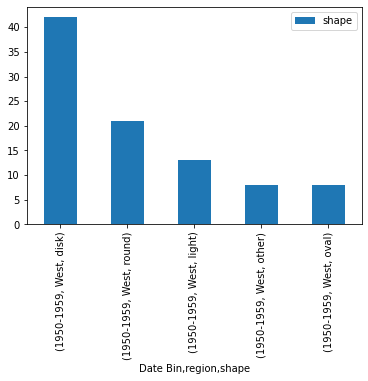

In [538]:
max_shapes.groupby('region').plot(kind='bar')

In [515]:
date_shape_50 = date_state_shape.loc[date_state_shape['Date Bin'] == "1950-1959"]
date_shape_50.head()

,Date Bin,state,shape,count
96,1950-1959,ca,disk,18
107,1950-1959,ca,round,14
976,1950-1959,tx,disk,14
756,1950-1959,ny,disk,12
102,1950-1959,ca,light,10


In [513]:
max_shapes = date_shape_50.groupby(['state']).max('count')
max_shapes.head()

,count
state,
ak,3
al,2
ar,2
az,1
ca,18


In [508]:
max_shapes = date_shape_50.groupby('state')['shape'].value_counts().groupby('state').head()
max_shapes

state  shape   
ak     changing    1
       chevron     1
       cigar       1
       cone        1
       crescent    1
                  ..
wy     changing    1
       chevron     1
       cigar       1
       cone        1
       crescent    1
Name: shape, Length: 260, dtype: int64

In [442]:
date_shape.sort_index().index

Int64Index([  8,  14,  15,  19,  24,  30,  36,  37,  38,  41,  43,  46,  52,
             54,  58,  59,  60,  62,  63,  65,  67,  68,  74,  76,  78,  80,
             81,  82,  84,  85,  87,  88,  89,  90,  94,  95,  96,  97,  98,
             99, 100, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113,
            115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 128, 129,
            130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143,
            144, 146, 147, 148, 150, 151, 152, 153],
           dtype='int64')

In [444]:
ufo_df.plot()

plt.show()

ValueError: Date ordinal -3336652.2 converts to -7166-07-22T19:12:00.000000 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

<AxesSubplot:ylabel='Date Bin'>

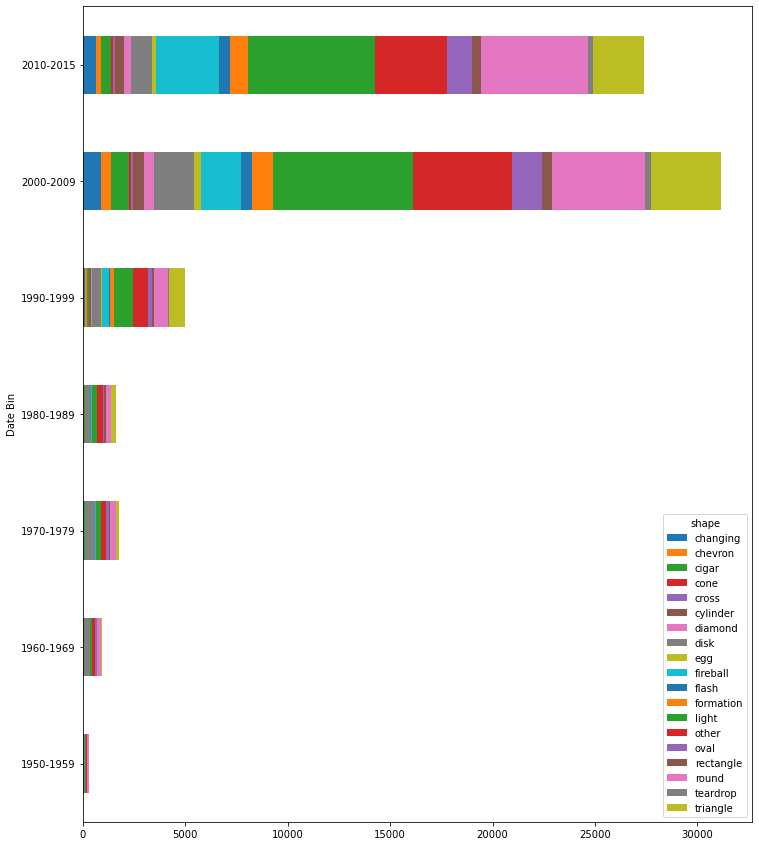

In [443]:
date_shape.groupby(['Date Bin', 'shape'])['count'].sum().unstack().plot(kind='barh', figsize=(12,15))

In [56]:
state_shape = ufo_df.groupby(['state', 'shape']).size().reset_index(name='count')
state_shape.head()

,state,shape,count
0,ab,changing,4
1,ab,chevron,2
2,ab,cigar,10
3,ab,circle,29
4,ab,cone,4


In [118]:
ufo_df.loc['state']

KeyError: 'state'

In [95]:
state_shape.set_index('state', inplace=True)
state_shape.groupby('shape')['count'].plot(legend=True)

KeyError: "None of ['state'] are in the columns"

<AxesSubplot:xlabel='state'>

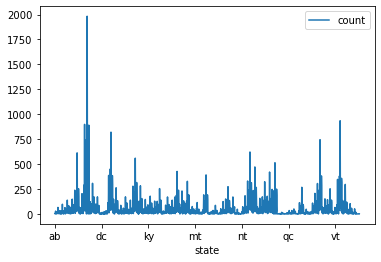

In [63]:
state_shape.plot(kind="bar")